<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/Bert_FCNN/Covid19FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
import kagglehub
import pandas as pd
import re
import os
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import h5py
from torch.utils.data import TensorDataset, DataLoader

In [28]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Kaggle dataset download
path = kagglehub.dataset_download("invalizare/covid-19-fake-news-dataset")
dataset_dir = "/root/.cache/kagglehub/datasets/invalizare/covid-19-fake-news-dataset/"

# Dynamically locate the Val.csv file
file_name = None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Val.csv" in file:
            file_name = os.path.join(root, file)
            break

# Load the dataset
df = pd.read_csv(file_name)

# Display dataset preview and statistics
print("Dataset preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

# Check and handle missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
df.dropna(subset=['tweet', 'label'], inplace=True)

# Rename columns for consistency
df.rename(columns={'tweet': 'text'}, inplace=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset preview:
   id                                              tweet label
0   1  Chinese converting to Islam after realising th...  fake
1   2  11 out of 13 people (from the Diamond Princess...  fake
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...  fake
3   4  Mike Pence in RNC speech praises Donald Trump’...  fake
4   5  6/10 Sky's @EdConwaySky explains the latest #C...  real

Dataset statistics:
                id
count  2140.000000
mean   1070.500000
std     617.909109
min       1.000000
25%     535.750000
50%    1070.500000
75%    1605.250000
max    2140.000000

Missing values per column:
id       0
tweet    0
label    0
dtype: int64


In [29]:
# Convert labels from strings to integers
label_mapping = {'fake': 0, 'true': 1}
df['label'] = df['label'].map(label_mapping)

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [14]:
!git clone https://github.com/AnastasiaKazanas/ANN-Final-Project.git

fatal: destination path 'ANN-Final-Project' already exists and is not an empty directory.


In [40]:
file_path = '/content/ANN-Final-Project/Bert_embeding_datasets/Covid19FakeNews.h5'

with h5py.File(file_path, 'r') as f:
    input_ids = np.array(f['input_ids'])

labels = torch.tensor(df['label'].values, dtype=torch.long)
labels[labels < 0] = 0

min_length = min(len(input_ids), len(labels))
input_ids = input_ids[:min_length]
labels = labels[:min_length]

input_ids = torch.tensor(input_ids, dtype=torch.float32)  # This conversion should be done once

# Split data
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2, random_state=42)

# Create Tensor datasets and Data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [43]:
# FCNN
class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FullyConnectedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model
input_size = input_ids.shape[1]
hidden_size = 100
num_classes = 2

model = FullyConnectedModel(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0000
Epoch [2/5], Loss: 0.0000
Epoch [3/5], Loss: 0.0000
Epoch [4/5], Loss: 0.0000
Epoch [5/5], Loss: 0.0000


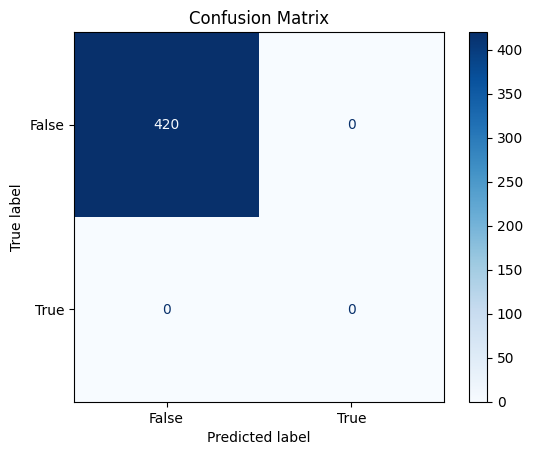

Accuracy of the model on the test data: 1.00


In [44]:
model.eval()
all_preds = []
all_targets = []

correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.tolist())
        all_targets.extend(targets.tolist())

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds, labels=[0, 1])  # Assuming '0' and '1' are your class labels
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy of the model on the test data: {accuracy:.2f}')
